# Multiple Linear Regression Car Pricing Use case

## Supress Warnings and import the required packages 

In [14]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Reading the car price data from the csv and looking into the dataframe

In [15]:
#inporting the Car price dataframe and looking into the dataframe
automobile = pd.read_csv('CarPrice_Assignment.csv', low_memory = True)
automobile.info()
automobile.describe()
automobile.shape
automobile.columns

#There is no null value in the data set.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

Index(['car_ID', 'symboling', 'CarName', 'fueltype', 'aspiration',
       'doornumber', 'carbody', 'drivewheel', 'enginelocation', 'wheelbase',
       'carlength', 'carwidth', 'carheight', 'curbweight', 'enginetype',
       'cylindernumber', 'enginesize', 'fuelsystem', 'boreratio', 'stroke',
       'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg',
       'price'],
      dtype='object')

### Creating the function to calculate the variance inflation factor to check multicollinearity

In [16]:
def Vif(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

### Creating the lists containing name of categorical , numerical and other columns in automobile dataframe

In [17]:
char_col = ['fueltype', 'aspiration', 'doornumber', 'enginelocation']
categorical_col = ['carbody', 'drivewheel', 'enginetype', 'cylindernumber', 'fuelsystem', 'Company_Name']
numerical_col = ['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm',
                 'citympg', 'highwaympg', 'price' ]

## Data Preparation

### Correcting the column name and label encoding

In [18]:
#Retreving the company name from the car name
automobile['Company_Name'] = automobile.CarName.str.split(' ',0).str[0]
#Checking the company names in the company name column
companies_Name = list(automobile['Company_Name'].unique())
#replacing the worng company name to correct one.
automobile.replace(to_replace =['vw', 'vokswagen'], value = 'volkswagen', inplace=True)
automobile.replace(to_replace ='toyouta', value = 'toyota', inplace = True)
automobile.replace(to_replace ='maxda', value = 'mazda', inplace = True)
automobile.replace(to_replace ='porcshce', value = 'porsche', inplace = True)
#converting the case of the string
automobile['Company_Name'] = automobile['Company_Name'].str.upper()
#Converting the char col to 0, 1 
automobile[char_col] = automobile[char_col].apply(lambda x: x.map({'gas':'1', 'diesel':'0', 'std':'1', 'turbo':'0', 'two':'1', 'four':'0', 'front':'1', 'rear':'0'}))
#droppig the car_id and car name column
automobile.drop(['CarName', 'car_ID'], axis = 1, inplace= True)
# Label encoding of the categorical column 
automobile = pd.concat([automobile, pd.get_dummies(automobile[categorical_col], drop_first = True)], axis=1)


## Plot the box plot for various features against price.

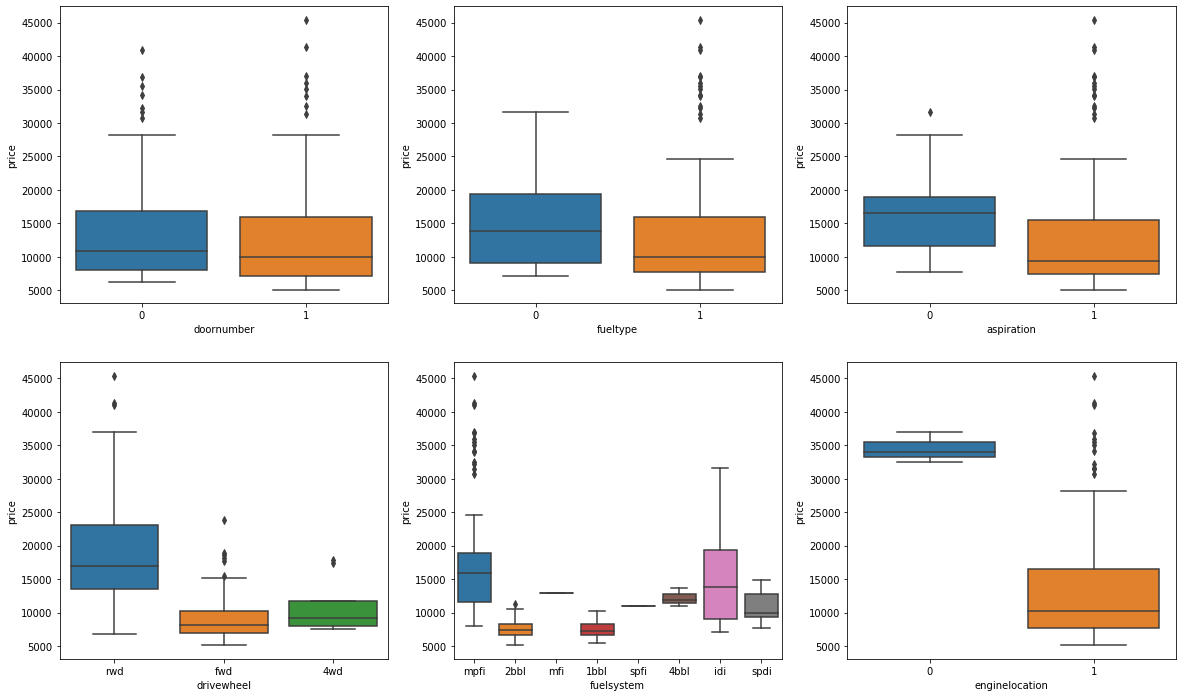

In [19]:
plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.boxplot(x = 'doornumber', y = 'price', data = automobile)
plt.subplot(2,3,2)
sns.boxplot(x = 'fueltype', y = 'price', data = automobile)
plt.subplot(2,3,3)
sns.boxplot(x = 'aspiration', y = 'price', data = automobile)
plt.subplot(2,3,4)
sns.boxplot(x = 'drivewheel', y = 'price', data = automobile)
plt.subplot(2,3,5)
sns.boxplot(x = 'fuelsystem', y = 'price', data = automobile)
plt.subplot(2,3,6)
sns.boxplot(x = 'enginelocation', y = 'price', data = automobile)
plt.show()


## Plot the scatter plot for various features against price.

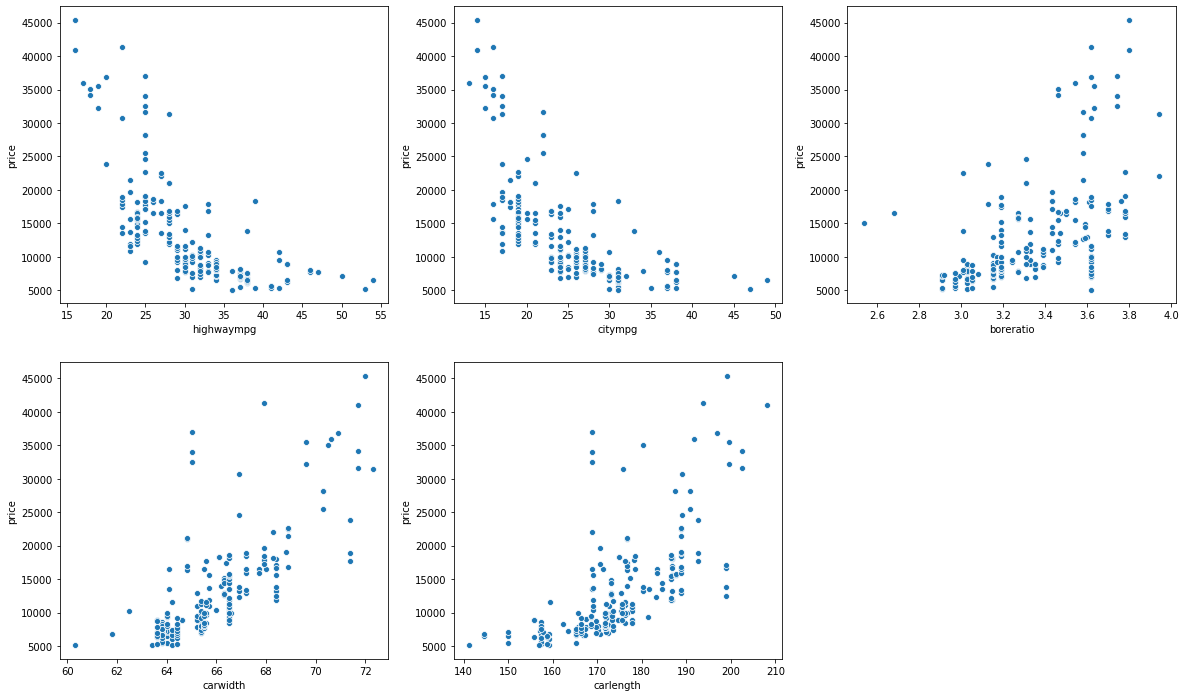

In [20]:

plt.figure(figsize=(20, 12))
plt.subplot(2,3,1)
sns.scatterplot(x = 'highwaympg', y = 'price', data = automobile)
plt.subplot(2,3,2)
sns.scatterplot(x = 'citympg', y = 'price', data = automobile)
plt.subplot(2,3,3)
sns.scatterplot(x = 'boreratio', y = 'price', data = automobile)
plt.subplot(2,3,4)
sns.scatterplot(x = 'carwidth', y = 'price', data = automobile)
plt.subplot(2,3,5)
sns.scatterplot(x = 'carlength', y = 'price', data = automobile)
plt.show()

In [21]:
automobile.columns
#dropping the categorical column
automobile.drop(categorical_col, inplace = True, axis = 1)

### Splitting the dataset into train and test and Scaling the numerical column 

In [22]:
df_train, df_test = train_test_split(automobile, test_size =.3, random_state =100)
scaler = MinMaxScaler()
df_train[numerical_col] = scaler.fit_transform(df_train[numerical_col])

y_train = df_train.pop('price')
X_train = df_train

### Fitting the linear regression model and recrussive feature elemination

In [23]:
#Fitting the linear regression model
lm = LinearRegression()
lm.fit(X_train, y_train)
#initialising recrussive feature elemination to select the 10 features
rfe = RFE(lm,10)
#Fitting the  recrussive feature elemination
rfe.fit(X_train, y_train)

print(list(zip(X_train.columns, rfe.support_, rfe.ranking_)))
#Creating the list of top 10 column name 
col = X_train.columns[rfe.support_]
print(col)
#Converting all the colum to float datatype
X_train_rfe = X_train[col].astype(float)

print(X_train.columns[~rfe.support_])

[('symboling', False, 54), ('fueltype', False, 25), ('aspiration', False, 14), ('doornumber', False, 51), ('enginelocation', True, 1), ('wheelbase', False, 17), ('carlength', False, 21), ('carwidth', True, 1), ('carheight', False, 18), ('curbweight', True, 1), ('enginesize', True, 1), ('boreratio', True, 1), ('stroke', False, 2), ('compressionratio', False, 26), ('horsepower', False, 15), ('peakrpm', False, 16), ('citympg', False, 39), ('highwaympg', False, 27), ('carbody_hardtop', False, 31), ('carbody_hatchback', False, 30), ('carbody_sedan', False, 32), ('carbody_wagon', False, 33), ('drivewheel_fwd', False, 53), ('drivewheel_rwd', False, 42), ('enginetype_dohcv', False, 12), ('enginetype_l', False, 7), ('enginetype_ohc', False, 55), ('enginetype_ohcf', False, 10), ('enginetype_ohcv', False, 41), ('enginetype_rotor', True, 1), ('cylindernumber_five', False, 5), ('cylindernumber_four', False, 4), ('cylindernumber_six', False, 29), ('cylindernumber_three', True, 1), ('cylindernumber_t

### Removing the columns based on high vif or/and high P value

In [24]:
#Adding the constant column into the dataframe.  and fitting the dataframe and printing the VIF
X_train_rfe = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train, X_train_rfe).fit()
print(lm.summary())
Vif(X_train_rfe)


#Removing the column curbweight and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('cylindernumber_twelve', axis =1)
lm = sm.OLS(y_train, X_train_rfe).fit()
lm.summary()
Vif(X_train_rfe)


#Removing the column curbweight and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('curbweight', axis=1)
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()
print(lm.summary())
Vif(X_train_rfe)


#Removing the column boreratio and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('boreratio', axis=1)
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()
print(lm.summary())
Vif(X_train_rfe)


#Removing the column Company_Name_PORSCHE and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('Company_Name_PORSCHE', axis=1)
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()
print(lm.summary())
Vif(X_train_rfe)


#Removing the column carwidth and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('carwidth', axis=1)
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()
print(lm.summary())
Vif(X_train_rfe)


#Removing the column const and fitting the dataframe and printing the VIF
X_train_rfe = X_train_rfe.drop('const', axis=1)
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()
print(lm.summary())
Vif(X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     137.1
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.21e-64
Time:                        13:19:48   Log-Likelihood:                 190.87
No. Observations:                 143   AIC:                            -359.7
Df Residuals:                     132   BIC:                            -327.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.17

               Features     VIF
0                 const  156.08
3            enginesize    3.02
2              carwidth    2.75
4      enginetype_rotor    1.12
6      Company_Name_BMW    1.09
1        enginelocation    1.08
5  cylindernumber_three    1.05
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sun, 26 Jan 2020   Prob (F-statistic):           1.11e-51
Time:                        13:19:48   Log-Likelihood:                 145.48
No. Observations:                 143   AIC:                            -279.0
Df Residuals:                     137   BIC:                            -261.2
Df Model:                           5                                         
Covariance Type:            nonro

## Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

0.001281314640110231


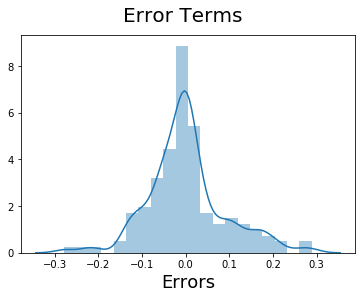

In [25]:
y_train_price = lm.predict(X_train_rfe)
fig = plt.figure()
sns.distplot((y_train - y_train_price), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   
print((y_train - y_train_price).mean())

## Making Predictions

Applying the scaling on the test sets. Dividing into X_test and y_test and predicting the data

In [26]:
df_test[numerical_col] = scaler.transform(df_test[numerical_col])
y_test = df_test.pop('price')
X_test = df_test[X_train_rfe.columns].astype(float)
y_pred = lm.predict(X_test)

## Model Evaluation

Text(0, 0.5, 'y_pred')

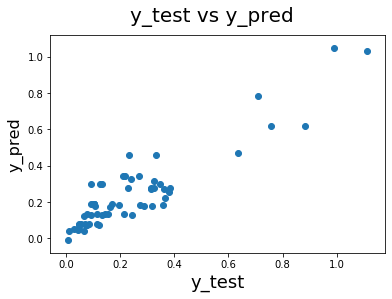

In [27]:
fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label